In [92]:
import cv2
import os   
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, measure, data,morphology
from skimage.filters import threshold_otsu, threshold_local
from skimage.feature import graycomatrix,graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import networkx as nx



## Representación y descripción de características

Representación por relleno de regiones. Identificar los objetos en una imagen binaria y colorear
cada región detectada. Sugerencia: scikit-image: measure.label, regionprops, label2rgb.

In [22]:
img = data.coins()

threshold = threshold_otsu(img)
img = img > threshold
img = morphology.remove_small_objects(img, 20)

Se detectaron 26 regiones.


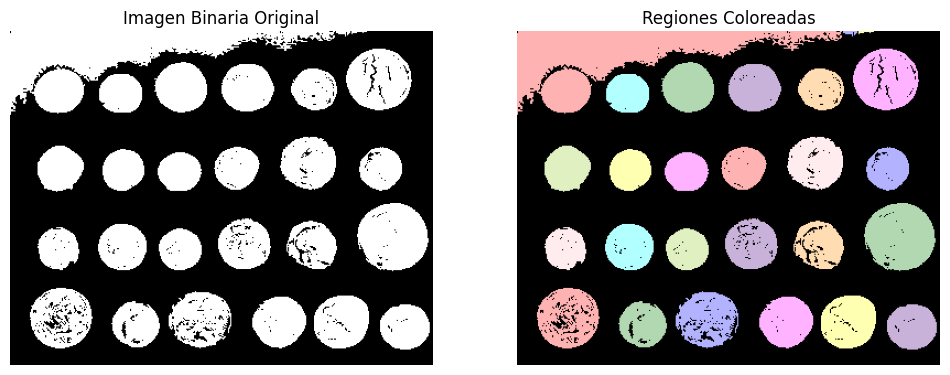

In [37]:


labels = measure.label(img, connectivity=2)


colored = color.label2rgb(labels, image=img, bg_label=0)

print(f"Se detectaron {labels.max()} regiones.")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagen Binaria Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored)
plt.title('Regiones Coloreadas')
plt.axis('off')

plt.show()


Cálculo de propiedades geométricas. Extraer área, perímetro, excentricidad y compacidad de cada región segmentada. Sugerencia: regionprops de skimage.measure

In [38]:
props = measure.regionprops(labels)

def get_compactness(region):
    area = region.area
    perimeter = region.perimeter
    return (perimeter**2) / (4 * 3.1416 * area) if area > 0 else 0

print("\nPropiedades geométricas de cada región:")
for i, prop in enumerate(props, 1):
    area = prop.area
    perimeter = prop.perimeter
    eccentricity = prop.eccentricity
    compactness = get_compactness(prop)

    print(f"Región {i}: Área={area}, Perímetro={perimeter:.2f}, Excentricidad={eccentricity:.2f}, Compacidad={compactness:.2f}")


Propiedades geométricas de cada región:
Región 1: Área=8755.0, Perímetro=1265.30, Excentricidad=0.98, Compacidad=14.55
Región 2: Área=37.0, Perímetro=27.04, Excentricidad=0.96, Compacidad=1.57
Región 3: Área=21.0, Perímetro=19.41, Excentricidad=0.99, Compacidad=1.43
Región 4: Área=2459.0, Perímetro=471.01, Excentricidad=0.33, Compacidad=7.18
Región 5: Área=1684.0, Perímetro=154.16, Excentricidad=0.30, Compacidad=1.12
Región 6: Área=1631.0, Perímetro=182.24, Excentricidad=0.39, Compacidad=1.62
Región 7: Área=1193.0, Perímetro=242.59, Excentricidad=0.39, Compacidad=3.93
Región 8: Área=1133.0, Perímetro=130.81, Excentricidad=0.43, Compacidad=1.20
Región 9: Área=1834.0, Perímetro=303.36, Excentricidad=0.37, Compacidad=3.99
Región 10: Área=1325.0, Perímetro=137.88, Excentricidad=0.34, Compacidad=1.14
Región 11: Área=1203.0, Perímetro=189.38, Excentricidad=0.38, Compacidad=2.37
Región 12: Área=1133.0, Perímetro=205.93, Excentricidad=0.33, Compacidad=2.98
Región 13: Área=1129.0, Perímetro=12

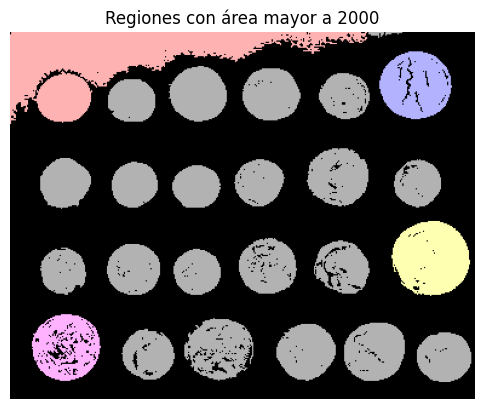

In [39]:
# mostrar solo regiones con area mayor a 1000
min_area = 2000
filtered_labels = np.zeros_like(labels)

for region in props:
    if region.area >= min_area:
        filtered_labels[labels == region.label] = region.label
colored_filtered = color.label2rgb(filtered_labels, image=img, bg_label=0)
plt.figure(figsize=(6, 6))
plt.imshow(colored_filtered)
plt.title(f'Regiones con área mayor a {min_area}')
plt.axis('off')
plt.show()


Descriptores de textura con GLCM. Calcular contraste, correlación y homogeneidad de regiones
usando matrices de co-ocurrencia. skimage.feature.greycomatrix, greycoprops

In [43]:
print(len(props))

26


In [ ]:
print("\nDescriptores de textura GLCM por región:")
for i, prop in enumerate(props, 1):
    minr, minc, maxr, maxc = prop.bbox
    region_intensity = img[minr:maxr, minc:maxc]
    region_mask = prop.image  # mascara binaria de la región

    # convertir a 8 bits o tiene overflow
    region_gray = (region_intensity * 255).astype(np.uint8)
    region_gray = region_gray * region_mask  # aplicar la máscara


    # GLCM con distancia 1 y ángulo 0°
    glcm = graycomatrix(region_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    print(f"Región {i}: Contraste={contrast:.2f}, Correlación={correlation:.2f}, Homogeneidad={homogeneity:.2f}")


Descriptores de textura GLCM por región:
Región 1: Contraste=1586.05, Correlación=0.95, Homogeneidad=0.98
Región 2: Contraste=13005.00, Correlación=0.59, Homogeneidad=0.80
Región 3: Contraste=6669.23, Correlación=0.79, Homogeneidad=0.90
Región 4: Contraste=6160.06, Correlación=0.75, Homogeneidad=0.91
Región 5: Contraste=2376.03, Correlación=0.89, Homogeneidad=0.96
Región 6: Contraste=2831.37, Correlación=0.86, Homogeneidad=0.96
Región 7: Contraste=5133.55, Correlación=0.78, Homogeneidad=0.92
Región 8: Contraste=2395.66, Correlación=0.86, Homogeneidad=0.96
Región 9: Contraste=4307.91, Correlación=0.82, Homogeneidad=0.93
Región 10: Contraste=2530.01, Correlación=0.89, Homogeneidad=0.96
Región 11: Contraste=4147.94, Correlación=0.83, Homogeneidad=0.94
Región 12: Contraste=4662.98, Correlación=0.81, Homogeneidad=0.93
Región 13: Contraste=2774.89, Correlación=0.87, Homogeneidad=0.96
Región 14: Contraste=2810.60, Correlación=0.86, Homogeneidad=0.96
Región 15: Contraste=2900.56, Correlación=

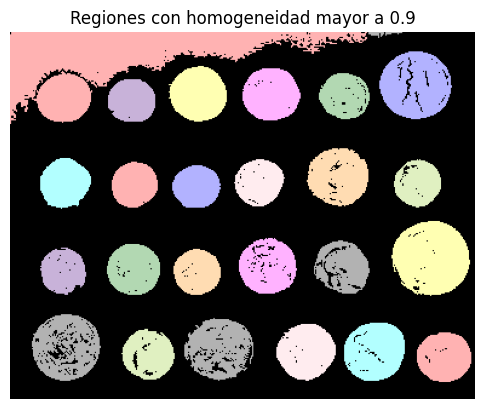

In [47]:
# mostramos las regiones con homogeneidad mayor a un num
min_homogeneity = 0.9
filtered_labels_texture = np.zeros_like(labels)

for region in props:
    minr, minc, maxr, maxc = region.bbox
    region_intensity = img[minr:maxr, minc:maxc]
    region_mask = region.image  # máscara booleana de la región

    # Asegurar que los valores estén en 8 bits (niveles de gris de 0 a 255)
    region_gray = (region_intensity * 255).astype(np.uint8)
    region_gray = region_gray * region_mask  # aplicar la máscara

    # GLCM con distancia 1 y ángulo 0°
    glcm = graycomatrix(region_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    if homogeneity >= min_homogeneity:
        filtered_labels_texture[labels == region.label] = region.label

colored_filtered_texture = color.label2rgb(filtered_labels_texture, image=img, bg_label=0)
plt.figure(figsize=(6, 6))
plt.imshow(colored_filtered_texture)
plt.title(f'Regiones con homogeneidad mayor a {min_homogeneity}')
plt.axis('off')
plt.show()

Relación espacial entre regiones. Determinar si las regiones están adyacentes o si una está contenida en otra. skimage.measure.regionprops + análisis de coordenadas / bounding boxes.

In [51]:
print("\nRelaciones espaciales entre regiones (adyacencia e inclusión):")

n = len(props)
for i in range(n):
    for j in range(i + 1, n):
        a = props[i]
        b = props[j]

        # Bounding boxes
        minr_a, minc_a, maxr_a, maxc_a = a.bbox
        minr_b, minc_b, maxr_b, maxc_b = b.bbox

        # Expand A bbox un píxel para ver si toca B
        expanded_a = (
            minr_a - 1, minc_a - 1,
            maxr_a + 1, maxc_a + 1
        )

        # son adyacentes si el bbox de B toca el bbox expandido de A
        overlap_row = not (maxr_b < expanded_a[0] or minr_b > expanded_a[2])
        overlap_col = not (maxc_b < expanded_a[1] or minc_b > expanded_a[3])
        if overlap_row and overlap_col:
            print(f"Región {i+1} y Región {j+1} son ADYACENTES.")

        # hay inclusión si el bbox de A contiene al bbox de B
        if (
            minr_a <= minr_b and minc_a <= minc_b and
            maxr_a >= maxr_b and maxc_a >= maxc_b
        ):
            print(f"Región {j+1} está CONTENIDA en Región {i+1}.")



Relaciones espaciales entre regiones (adyacencia e inclusión):
Región 1 y Región 2 son ADYACENTES.
Región 1 y Región 5 son ADYACENTES.
Región 5 está CONTENIDA en Región 1.
Región 1 y Región 6 son ADYACENTES.
Región 6 está CONTENIDA en Región 1.
Región 1 y Región 7 son ADYACENTES.
Región 1 y Región 8 son ADYACENTES.
Región 8 está CONTENIDA en Región 1.
Región 2 y Región 3 son ADYACENTES.


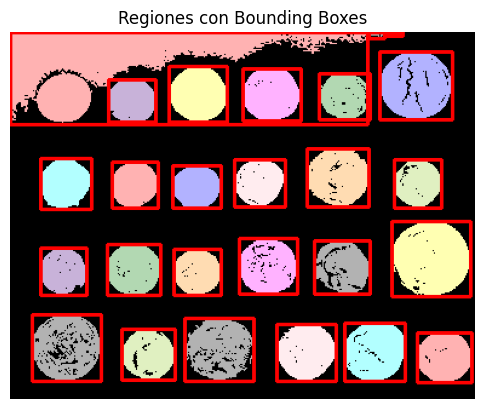

In [ ]:
# mostrar bounding boxes de las regiones
for prop in props:
    minr, minc, maxr, maxc = prop.bbox
    cv2.rectangle(colored_filtered_texture, (minc, minr), (maxc, maxr), (1, 0, 0), 2)
    
plt.figure(figsize=(6, 6))
plt.imshow(colored_filtered_texture)
plt.title('Regiones con Bounding Boxes')
plt.axis('off')
plt.show()


## Reconocimiento de Patrones

Template Matching. Buscar una figura conocida dentro de una imagen mediante una plantilla.
Sugerencia: cv2.matchTemplate, cv2.minMaxLoc

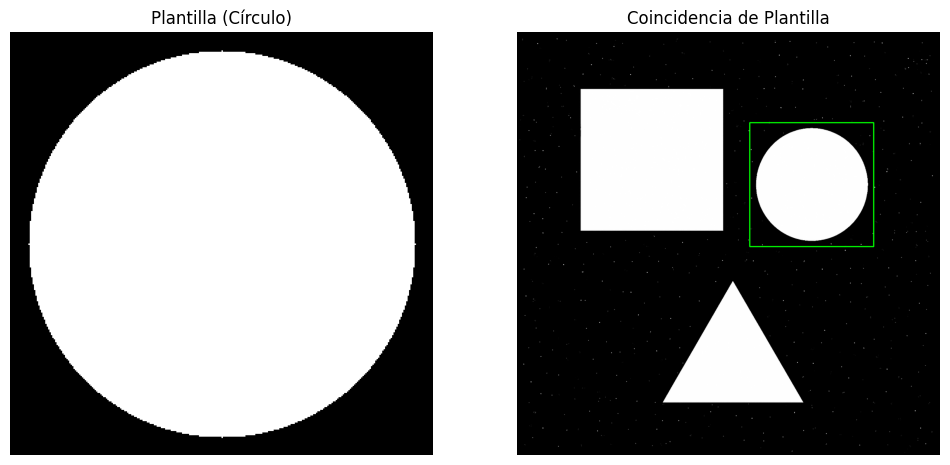

In [68]:
# template: un circulo
size = 300
template = np.zeros((size, size), dtype=np.uint8)
cv2.circle(template, (size//2, size//2), (size-25)//2, 1, -1)

path = 'img/bin1.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

h,w = template.shape
result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# rectangulo en la mejor coincidencia
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
top_left = max_loc

bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img_color, top_left, bottom_right, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))

# mostrar la plantilla
plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title('Plantilla (Círculo)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_color)
plt.title('Coincidencia de Plantilla')
plt.axis('off')

plt.show()


Clasificaci´on basada en caracter´ısticas. Extraer caracter´ısticas simples (como ´area o textura) de
regiones segmentadas y clasificarlas usando KNN. Sugerencia: scikit-learn + descriptores de region-
props.

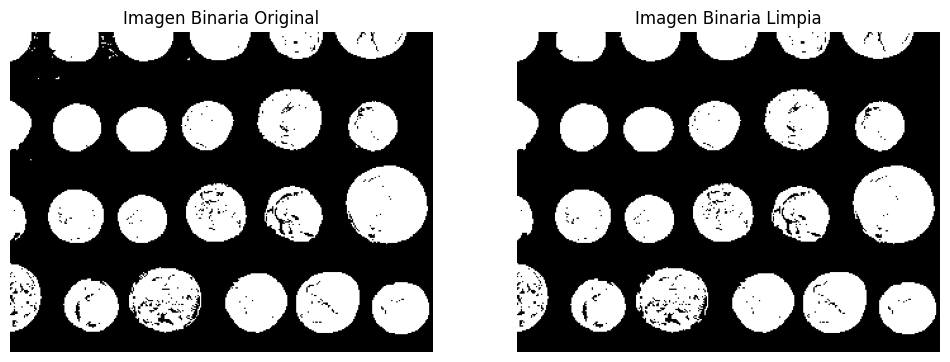

Se encontraron 3 clusters.
[1 1 1 1 1 1 0 1 1 1 1 1 2 0 0 0 1 1 1 0 0 0 0 0]


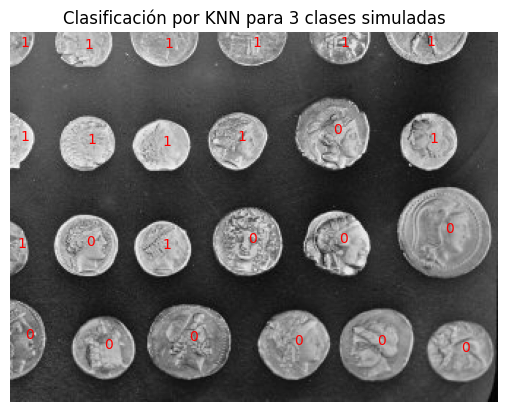

In [91]:
# imagen de monedas again

image = data.coins()
# cropear los primeros 50 píxeles de la imagen
image = image[50:,50:]
thresh = threshold_otsu(image)

binary = image > thresh
cleaned = morphology.remove_small_objects(binary, 50)
# mostrar mascara binaria y limpiar objetos pequeños
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(binary, cmap='gray')
plt.title('Imagen Binaria Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cleaned, cmap='gray')
plt.title('Imagen Binaria Limpia')
plt.axis('off')
plt.show()
labels = measure.label(cleaned)

# caracteristicas por region
features = []
for region in measure.regionprops(labels, intensity_image=image):
    # filtrar regiones mas chicas

    if region.area < 100:
        continue
    area = region.area
    perimeter = region.perimeter
    eccentricity = region.eccentricity
    compactness = get_compactness(region)

    # GLCM contraste como descriptor de textura
    minr, minc, maxr, maxc = region.bbox
    region_img = image[minr:maxr, minc:maxc]
    region_mask = region.image
    region_vals = region_img * region_mask
    gray_region = (region_vals * 255 / region_vals.max()).astype(np.uint8)

    glcm = graycomatrix(gray_region, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    # features: area, excentricidad, compacidad, contraste
    features.append([area, eccentricity, compactness, contrast])

X = np.array(features)

# kmeans para clustering (solo dos clusters)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y = kmeans.labels_

print(f"Se encontraron {len(np.unique(y))} clusters.")
print(y)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_scaled, y)


y_pred = knn.predict(X_scaled)



for i, region in enumerate(measure.regionprops(labels)):
    if region.area < 100: continue
    cy, cx = region.centroid
    plt.text(cx, cy, str(y_pred[i]), color='red', fontsize=10)

plt.imshow(image, cmap='gray')
plt.title("Clasificación por KNN para 3 clases simuladas")
plt.axis('off')
plt.show()


Reconocimiento estructural. Representar caracteres como grafos de líneas y nodos. Clasificarlo según su estructura. Sugerencia: Estructuras de grafos con networkx (librería de python).

In [100]:
img_path = 'img/bin4.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

img_bin = img > threshold_otsu(img)

skeleton = morphology.skeletonize(img_bin)


def get_neighbors(img, r, c):
    neighbors = [(r+dr, c+dc) for dr in [-1,0,1] for dc in [-1,0,1] if not (dr==0 and dc==0)]
    return [(nr,nc) for nr,nc in neighbors if 0 <= nr < img.shape[0] and 0 <= nc < img.shape[1] and img[nr,nc]]

nodes = []
for r in range(1, skeleton.shape[0]-1):
    for c in range(1, skeleton.shape[1]-1):
        if skeleton[r, c]:
            deg = sum(skeleton[nr, nc] for nr, nc in get_neighbors(skeleton, r, c))
            if deg != 2:  # extremos, cruces, curvas
                nodes.append((r, c))

# grafo conectando píxeles vecinos
G = nx.Graph()
for r in range(skeleton.shape[0]):
    for c in range(skeleton.shape[1]):
        if skeleton[r, c]:
            G.add_node((r, c))
            for nr, nc in get_neighbors(skeleton, r, c):
                if skeleton[nr, nc]:
                    G.add_edge((r, c), (nr, nc))

# simplificar el grafo: eliminar aristas que no conectan nodos extremos
G_simple = nx.Graph()
for n1 in nodes:
    for n2 in nodes:
        if n1 != n2 and nx.has_path(G, n1, n2):
            try:
                path = nx.shortest_path(G, n1, n2)
                if all(p not in nodes for p in path[1:-1]):
                    G_simple.add_edge(n1, n2)
            # TODO: ver por que a veces falla
            except:
                pass


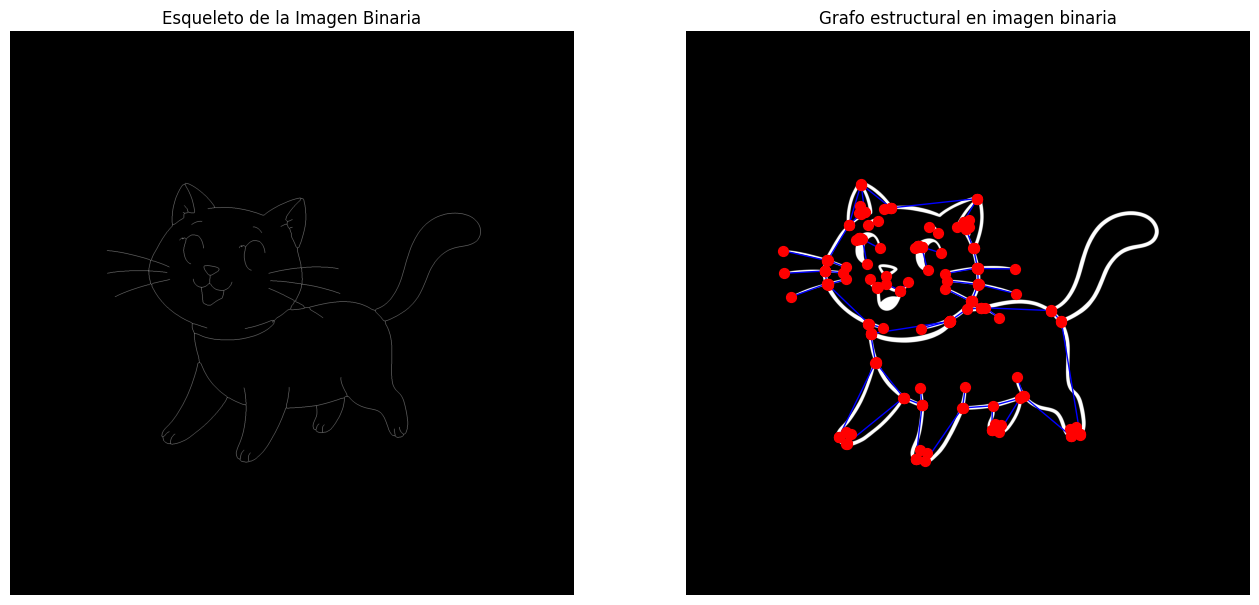

In [101]:

# mostrar
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(skeleton, cmap='gray')
plt.title("Esqueleto de la Imagen Binaria")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
nx.draw(G_simple, pos={n: (n[1], n[0]) for n in G_simple.nodes}, node_size=50, node_color='r', edge_color='b')
plt.title("Grafo estructural en imagen binaria")
plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train_cat, epochs=5, batch_size=64, validation_split=0.1)


test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"\nPrecisión en test: {test_acc:.2f}")


2025-06-02 23:24:48.159683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 23:24:48.167218: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 23:24:48.303042: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 23:24:48.362058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 23:24:48.464527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/home/andres/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8603 - loss: 0.4675 - val_accuracy: 0.9802 - val_loss: 0.0637
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9807 - loss: 0.0630 - val_accuracy: 0.9867 - val_loss: 0.0481
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9884 - loss: 0.0384 - val_accuracy: 0.9903 - val_loss: 0.0369
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9901 - loss: 0.0310 - val_accuracy: 0.9897 - val_loss: 0.0372
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9919 - loss: 0.0229 - val_accuracy: 0.9890 - val_loss: 0.0405
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9878 - loss: 0.0446

🔍 Precisión en test: 99.03%
